In [1]:
import os

import glob
import numpy as np
import pandas as pd

import openslide
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt 

from utils import *
from utils_vis import plot_oneline, show_roi, patch_overlay_wsi

import warnings
warnings.filterwarnings('ignore', 
    message='.*Attempting to register factory for plugin.*')
warnings.filterwarnings('ignore',
    message='.*computation placer already registered.*')

2025-05-05 22:10:41.305840: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 22:10:44.382099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746479445.743050 2103394 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746479446.054673 2103394 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746479449.307088 2103394 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Load WSI & foreground tissue mask

In [2]:
wsi_pt = '../project-data/examples/17064108_FPE_1.ndpi'
require_bounds = ".mrxs" in wsi_pt 
mask_pt = '../project-data/examples/17064108_FPE_1.ndpi_mask_use.png'

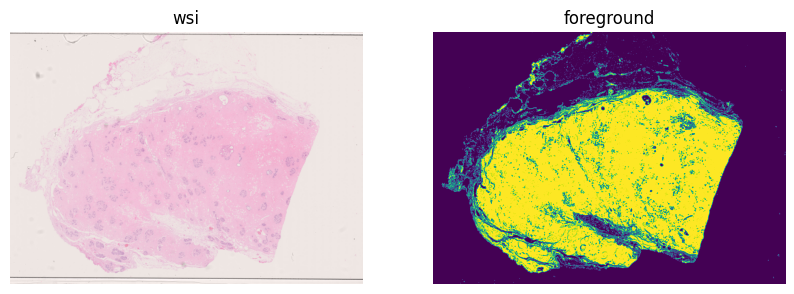

In [3]:
wsi = openslide.OpenSlide(wsi_pt)
im_wsi = wsi.read_region((0,0), wsi.level_count-1, wsi.level_dimensions[wsi.level_count-1]).convert('RGB')
im_mask = Image.open(mask_pt)
plot_oneline([im_wsi, im_mask], ['wsi', 'foreground'], (10,10))

### Whole slide tissue classification

In [4]:
# parameters
foreground_thes = 0.7
patch_size_microns = 128
model_type = 'TC_512'
IMAGE_SIZE = (512, 512)
free_space = False 
use_multithreading = True
max_workers = 8

In [5]:
# load model
model_weights = './data/TC_512px.h5'
model = get_TC(model_weights, image_size=IMAGE_SIZE, num_classes=3, output_features=False)

/cephfs/volumes/hpc_data_prj/cb_histology_data/8b8186f5-4ae0-4605-94c4-46d4ff4e62b0/Siyuan/Docker_test/nbtclassifier/NBT-Classifier/utils.py:41: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  net = MobileNet(include_top=False, input_shape=(image_size[0], image_size[1], 3))
I0000 00:00:1746479568.909948 2103394 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3234 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:17:00.0, compute capability: 8.0


In [6]:
# output dir
wsi_name = "17064108_FPE_1"
output_dir = os.path.join("../project-data/FEATUREs", wsi_name)
os.makedirs(output_dir, exist_ok=True)

In [7]:
# Convert physical patch size (microns) to pixel dimensions using WSI's MPP resolution
patch_size, _ = parse_patch_size(wsi, patch_size_microns)
print(patch_size)

579


In [8]:
# make WSI-level tissue classification 
TC_maskpt = os.path.join(output_dir, f"{wsi_name}_{model_type}_probmask.npy")
tissue_map = run_TC_one_slide(wsi, mask_pt, TC_maskpt, patch_size, foreground_thes, IMAGE_SIZE, model, free_space, use_multithreading, max_workers)

tc_map_path = os.path.join(output_dir, f"{wsi_name}_{model_type}.png")
save_tc_map(tissue_map, wsi_pt, tc_map_path)

Mask saved at ../project-data/examples/17064108_FPE_1.ndpi_mask_use.npy.
Preprocessing ../project-data/FEATUREs/17064108_FPE_1/17064108_FPE_1_TC_512...


Extracting patches from 17064108_FPE_1_TC_512_pattern: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 18753/18753 [1:16:27<00:00,  4.09it/s]


Tiles extracted for 17064108_FPE_1_TC_512_pattern: 18753 patches saved.
Vectorization completed for ../project-data/FEATUREs/17064108_FPE_1/17064108_FPE_1_TC_512.
Predicting tissue classes...


/scratch/users/k21066795/conda/nbtclassifier/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746445689.743160 2099349 service.cc:152] XLA service 0x7ce18c004f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746445689.743189 2099349 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.5gb, Compute Capability 8.0
2025-05-05 12:48:09.763727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746445690.009162 2099349 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-05 12:48:10

   3/2345 ━━━━━━━━━━━━━━━━━━━━ 1:41 43ms/step   

I0000 00:00:1746445708.493831 2099349 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 135s 49ms/step


Processing Patches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18753/18753 [00:00<00:00, 1225759.84it/s]


Tissue map saved at ../project-data/FEATUREs/17064108_FPE_1/17064108_FPE_1_TC_512_probmask.npy.
TC Map saved at ../project-data/FEATUREs/17064108_FPE_1/17064108_FPE_1_TC_512.png.


### Whole slide tissue class heatmaps

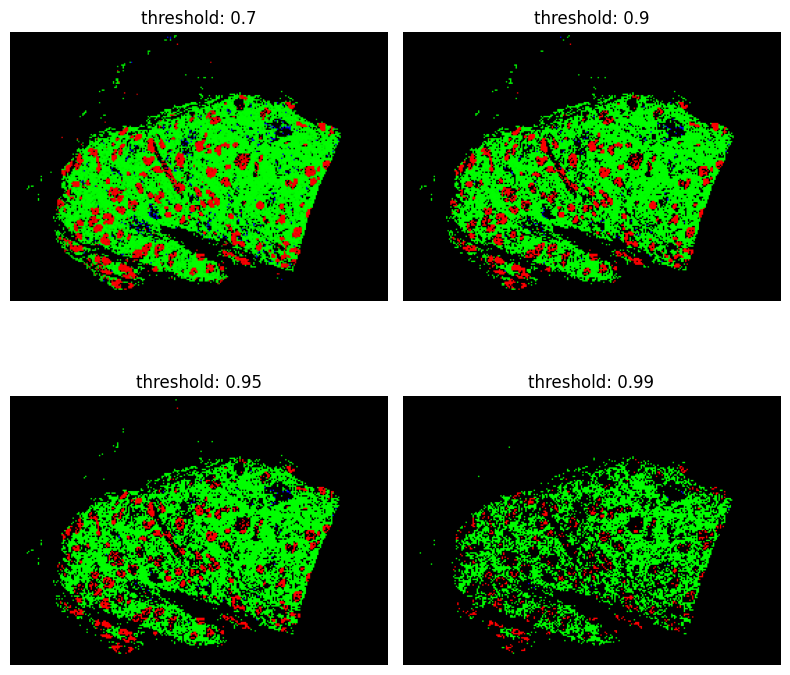

In [9]:
# Compare tissue classification confidence thresholds by masking low-confidence regions:
# - For thresholds [0.7, 0.9, 0.95, 0.99], set RGB=0 where confidence < threshold
# - Input: `tissue_map` (np.array[H,W,3]) with channels representing:
#   - Red: Epithelium confidence
#   - Green: Stroma confidence  
#   - Blue: Adipocytes confidence
# - Output: 2x2 grid of thresholded images (colored regions = high-confidence tissue, black = masked)

images = []
thresholds = [0.7, 0.9, 0.95, 0.99]
for threshold in thresholds:
    im = tissue_map.copy()
    im[:,:, 0][tissue_map[:,:, 0] < threshold] = 0
    im[:,:, 1][tissue_map[:,:, 1] < threshold] = 0
    im[:,:, 2][tissue_map[:,:, 2] < threshold] = 0
    images.append(im)


fig, axs = plt.subplots(2, 2, figsize=(8, 8))
counter = 0
for x in range(2):
    for y in range(2):
        axs[x, y].imshow(images[counter])
        axs[x, y].set_title(f'threshold: {thresholds[counter]}')
        axs[x, y].axis('off') 
        counter += 1
plt.tight_layout()
plt.show()

In [10]:
# save all classified patches
Allpatch_pt = f"{output_dir}/{wsi_name}_{model_type}_patch_all.csv"
cls_df = save_Allpatch(tissue_map, patch_size, Allpatch_pt) 

../project-data/FEATUREs/17064108_FPE_1/17064108_FPE_1_TC_512_patch_all.csv saved!


In [11]:
# convert into a .json file as pseudo annotation for the use of QuPath 
json_pt = f"{output_dir}/{wsi_name}_{model_type}_cls_wsi.json"
get_JSON(cls_df, json_pt, patch_size, require_bounds)
cls_df.head()

../project-data/FEATUREs/17064108_FPE_1/17064108_FPE_1_TC_512_cls_wsi.json saved!


,patch_id,grid_x,grid_y,orig_x,orig_y,TC_epi,TC_str,TC_adi,cls,cohort,wsi_id
0,17064108_FPE_1_0_0_579,0,0,0,0,0.0,0.0,0.0,0,FEATUREs,17064108_FPE_1
1,17064108_FPE_1_0_1_579,0,1,0,579,0.0,0.0,0.0,0,FEATUREs,17064108_FPE_1
2,17064108_FPE_1_0_2_579,0,2,0,1158,0.0,0.0,0.0,0,FEATUREs,17064108_FPE_1
3,17064108_FPE_1_0_3_579,0,3,0,1737,0.0,0.0,0.0,0,FEATUREs,17064108_FPE_1
4,17064108_FPE_1_0_4_579,0,4,0,2316,0.0,0.0,0.0,0,FEATUREs,17064108_FPE_1


## Lobule binary mask

In [12]:
upscale_factor = 32
small_objects=400000
roi_width = 250

../project-data/FEATUREs/17064108_FPE_1/17064108_FPE_1_TC_512_epi_(18,0,0,8704,6208)-mask.png saved!


(-0.5, 8703.5, 6207.5, -0.5)

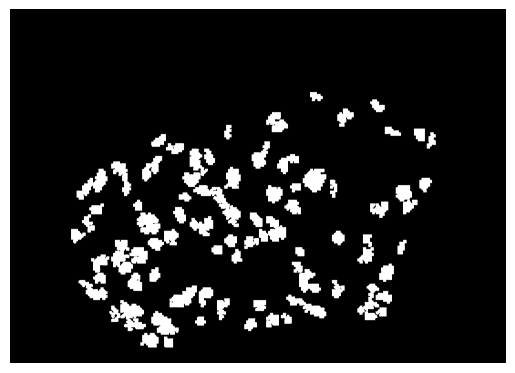

In [13]:
epi_mask, roi_width, wsi_mask_ratio = process_TCmask(wsi, tissue_map, upscale_factor, small_objects, roi_width)
epi_mask_pt = f"{output_dir}/{wsi_name}_{model_type}_epi_({int(wsi_mask_ratio)},0,0,{epi_mask.shape[1]},{epi_mask.shape[0]})-mask.png"
save_epi_mask(epi_mask, epi_mask_pt)
plt.imshow(epi_mask, cmap = 'gray')
plt.axis("off")

## ROI detection 

In [14]:
patch_pt = f"{output_dir}/{wsi_name}_{model_type}_patch_roi.csv"
patch_df = save_ROIpatch(tissue_map, epi_mask, wsi_mask_ratio, roi_width, patch_size, patch_pt)

There're 81 ROIs detected
Saved ../project-data/FEATUREs/17064108_FPE_1/17064108_FPE_1_TC_512_patch_roi.csv!


Saved ../project-data/FEATUREs/17064108_FPE_1/17064108_FPE_1_TC_512_bbx.png!


(-0.5, 8703.5, 6207.5, -0.5)

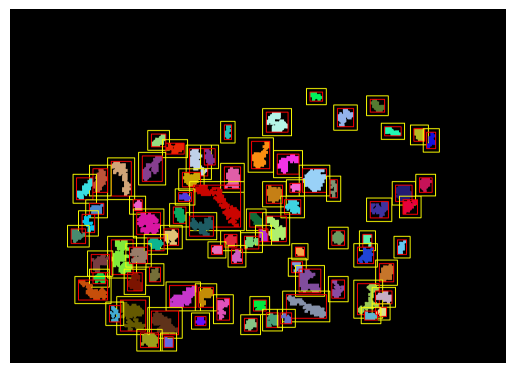

In [15]:
overlay_path = f"{output_dir}/{wsi_name}_{model_type}_bbx.png"
bbx_map = bbx_overlay(epi_mask, overlay_path, roi_width)
plt.imshow(bbx_map)
plt.axis('off')

There're 81 ROIs detected


(-0.5, 9184.5, 8604.5, -0.5)

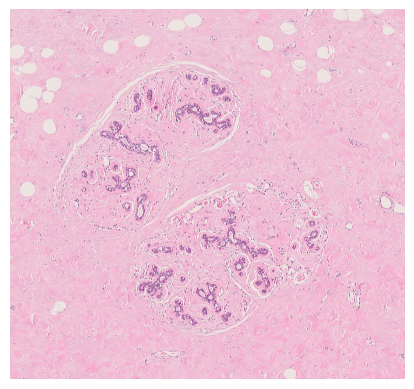

In [16]:
wsi_id = "17064108_FPE_1"
# get roi ids for all ROIs detected on the WSI
roi_ids = get_roi_ids(epi_mask, wsi_id, roi_width, wsi_mask_ratio)

## display a single ROI
im = show_roi(wsi, roi_ids[3])
plt.imshow(im)
plt.axis('off')

In [17]:
json_pt = f"{output_dir}/{wsi_name}_{model_type}_cls_roi.json"
get_JSON(patch_df, json_pt, patch_size, require_bounds)
patch_df.head()

../project-data/FEATUREs/17064108_FPE_1/17064108_FPE_1_TC_512_cls_roi.json saved!


,roi_id,patch_id,cls,TC_epi,TC_str,TC_adi,cohort,wsi_id,orig_x,orig_y
0,17064108_FPE_1_94248_25256_6286_5127,17064108_FPE_1_94248_25256_6286_5127_165_46_579,1,0.962390,0.037592,0.000017,FEATUREs,17064108_FPE_1,95535,26634
1,17064108_FPE_1_94248_25256_6286_5127,17064108_FPE_1_94248_25256_6286_5127_166_46_579,1,0.875106,0.124795,0.000100,FEATUREs,17064108_FPE_1,96114,26634
2,17064108_FPE_1_94248_25256_6286_5127,17064108_FPE_1_94248_25256_6286_5127_167_46_579,1,0.990265,0.009713,0.000022,FEATUREs,17064108_FPE_1,96693,26634
3,17064108_FPE_1_94248_25256_6286_5127,17064108_FPE_1_94248_25256_6286_5127_165_47_579,1,0.965307,0.034632,0.000061,FEATUREs,17064108_FPE_1,95535,27213
4,17064108_FPE_1_94248_25256_6286_5127,17064108_FPE_1_94248_25256_6286_5127_166_47_579,1,0.945871,0.053913,0.000216,FEATUREs,17064108_FPE_1,96114,27213


## Targeted patch selection

Total samples: 3120
Unique classes in sampled data: [1 2 3]


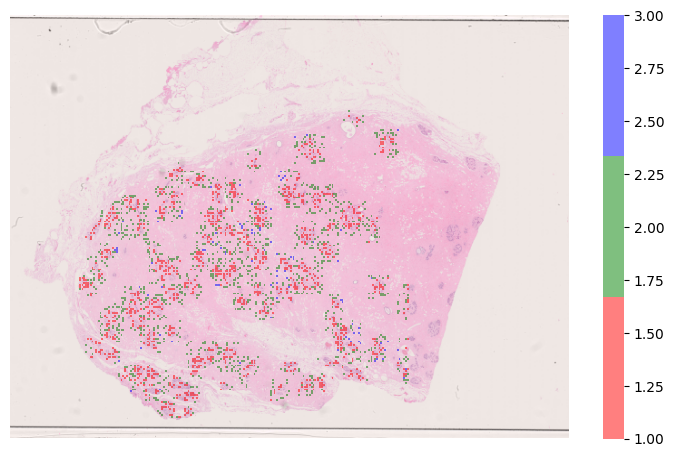

In [18]:
num2sample = 1500
sampled_patches = []
for cls in [1, 2, 3]:
    df_cls = patch_df[patch_df["cls"] == cls]
    df_cls_shuffled = df_cls.sample(frac=1, random_state=42)
    df_cls_sampled = df_cls_shuffled.head(num2sample)
    sampled_patches.append(df_cls_sampled)

patch_sampled = pd.concat(sampled_patches, ignore_index=True)
print(f"Total samples: {len(patch_sampled)}")
print(f"Unique classes in sampled data: {np.unique(patch_sampled['cls'])}")

fig = patch_overlay_wsi(patch_sampled, wsi_pt, patch_size, figsize=(9, 5.5))

### Alternatively, using TC_1024

Mask saved at ../project-data/examples/17064108_FPE_1.ndpi_mask_use.npy.
Preprocessing ../project-data/FEATUREs/17064108_FPE_1/17064108_FPE_1_TC1024probmask.npy...


Extracting patches from 17064108_FPE_1_TC1024probmask: 100%|██████████████████████████████| 4702/4702 [25:06<00:00,  3.12it/s]


Tiles extracted for 17064108_FPE_1_TC1024probmask: 4702 patches saved.
Vectorization completed for ../project-data/FEATUREs/17064108_FPE_1/17064108_FPE_1_TC1024probmask.npy.
Predicting tissue classes...


/scratch/users/k21066795/conda/nbtclassifier/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746481104.764406 2111148 service.cc:152] XLA service 0x72ef0c003340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746481104.764430 2111148 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.5gb, Compute Capability 8.0
2025-05-05 22:38:24.783094: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746481105.152661 2111148 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-05 22:38:26

  1/588 ━━━━━━━━━━━━━━━━━━━━ 4:54:53 30s/step

I0000 00:00:1746481134.284677 2111148 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


587/588 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step

2025-05-05 22:40:44.568541: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_667', 136 bytes spill stores, 136 bytes spill loads

2025-05-05 22:40:45.211346: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_667_0', 184 bytes spill stores, 412 bytes spill loads

2025-05-05 22:40:46.019934: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_667', 8 bytes spill stores, 8 bytes spill loads

2025-05-05 22:40:46.125445: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_667', 3852 bytes spill stores, 3848 bytes spill loads

2025-05-05 22:40:47.279758: I extern

588/588 ━━━━━━━━━━━━━━━━━━━━ 160s 222ms/step


Processing Patches: 100%|████████████████████████████████████████████████████████████| 4702/4702 [00:00<00:00, 1058367.36it/s]

Tissue map saved at ../project-data/FEATUREs/17064108_FPE_1/17064108_FPE_1_TC1024probmask.npy.


(-0.5, 135.5, 96.5, -0.5)

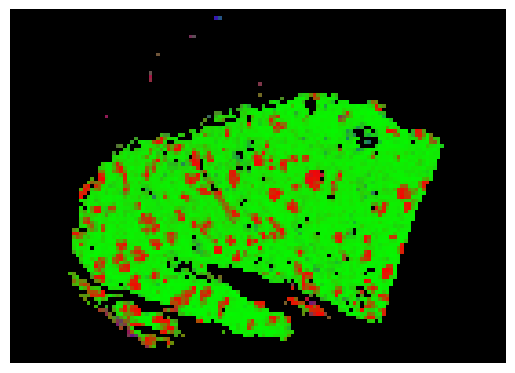

In [7]:
IMAGE_SIZE = (1024, 1024)
model_weights = './data/TC_1024px.h5'
model1024 = get_TC(model_weights, image_size=IMAGE_SIZE, num_classes=3, output_features=False)

patch_size, _ = parse_patch_size(wsi, patch_size_microns=256)
TC_maskpt = os.path.join(output_dir, f"{wsi_name}_TC1024probmask.npy")
tissue_map1024 = run_TC_one_slide(wsi, mask_pt, TC_maskpt, patch_size, foreground_thes, IMAGE_SIZE, model=model1024, free_space=False, use_multithreading=True, max_workers=8)

tissue_map1024[:, :, [1, 2]] = tissue_map1024[:, :, [2, 1]]
plt.imshow(tissue_map1024)
plt.axis('off')